In [6]:
import numpy as np
from scipy.stats import multivariate_normal

In [2]:
class GMM:
  def __init__(self, K, max_iter):
    self._K = K
    self._max_iter = max_iter
  
  def init_alpha(self):
    self._alpha = np.full(shape=self._K, fill_value=1/self._K)

  def init_to(self):
    self._to = np.full(shape=self._shape, fill_value=1/self._K)

  def init_muy(self):
    random_row = np.random.randint(low=0, high=self._n, size=self._K)
    self._muy = [self._X[row_idx, :] for row_idx in random_row]

  def init_epsilon(self):
    self._epsilon = [np.cov(self._X.T) for _ in range(self._K)]

  def initialize(self, X):
    self._shape = X.shape
    self._n, self._m = self._shape
    self._X = X

    self.init_alpha()
    self.init_to()
    self.init_muy()
    self.init_epsilon()

  def update_to(self, X) :
    likelihood = np.zeros((self._n, self._K))
    for i in range(self._K):
      distribution = multivariate_normal(
          mean = self._muy[i],
          cov = self._epsilon[i]
      )
      likelihood[:, i] = distribution.pdf(X)
    numerator = self._alpha * likelihood    # shape(N,K)
    denominator = numerator.sum(axis=1)[:, np.newaxis]
    to = numerator / denominator
    return to

  def e_step(self):
    self._to = self.update_to(self._X)
    self._alpha = self._to.mean(axis=0)

  def m_step(self):
    for i in range(self._K):
      to_k = self._to[:, [i]]   # shape(N,1)
      total_weight = to_k.sum()  
      self._muy[i] = (self._X * to_k).sum(axis=0) / total_weight    # shape(1,M)
      self._epsilon[i] = np.cov(self._X.T,
                                aweights=(to_k/total_weight).flatten(),
                                bias=True)
    
  def fit(self, X):
    self.initialize(X)
    for it in range(self._max_iter):
      self.e_step()
      self.m_step()

  def predict(self, Y):
    to = self.update_to(Y)
    return np.argmax(to, axis=1)


In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data

In [ ]:
gmm = GMM(K=3, max_iter=100)
gmm.fit(X)

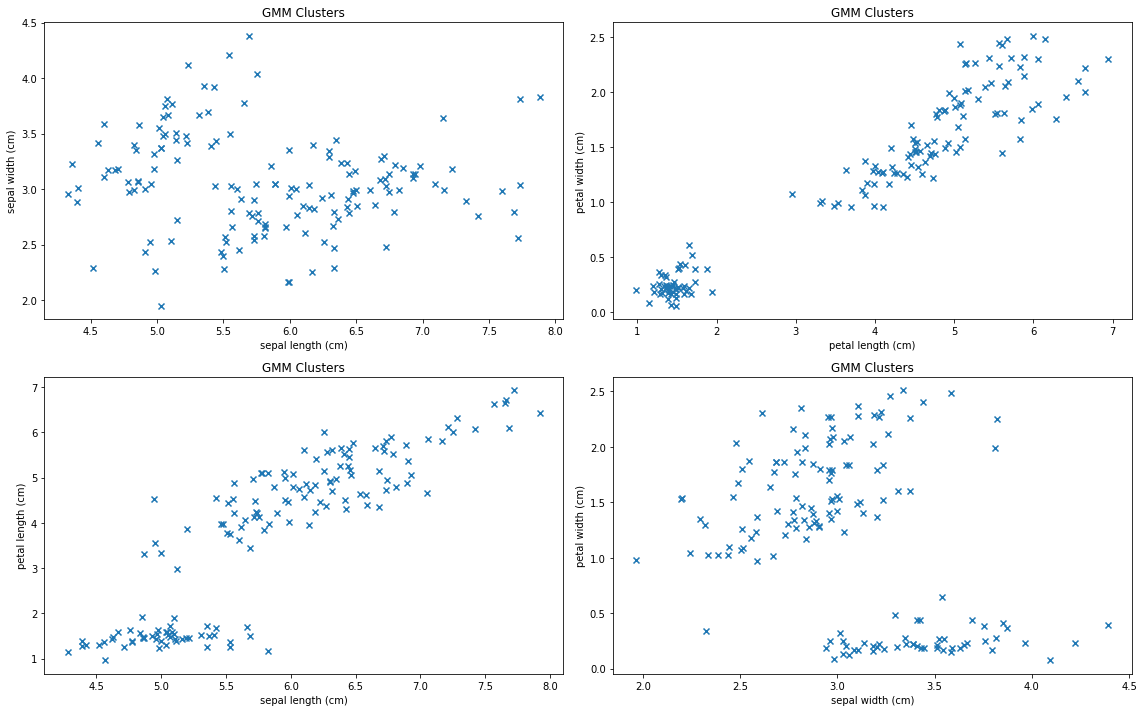

In [ ]:
import matplotlib.pyplot as plt

def jitter(x):
    return x + np.random.uniform(low=-0.05, high=0.05, size=x.shape)

def plot_axis_pairs(X, axis_pairs, clusters, classes):
    n_rows = len(axis_pairs) // 2
    n_cols = 2
    plt.figure(figsize=(16, 10))
    for index, (x_axis, y_axis) in enumerate(axis_pairs):
        plt.subplot(n_rows, n_cols, index+1)
        plt.title('GMM Clusters')
        plt.xlabel(iris.feature_names[x_axis])
        plt.ylabel(iris.feature_names[y_axis])
        plt.scatter(
            jitter(X[:, x_axis]), 
            jitter(X[:, y_axis]), 
            #c=clusters, 
            cmap=plt.cm.get_cmap('brg'),
            marker='x')
    plt.tight_layout()
    
plot_axis_pairs(
    X=X,
    axis_pairs=[ 
        (0,1), (2,3), 
        (0,2), (1,3) ],
    clusters=permuted_prediction,
    classes=iris.target)

In [ ]:
from scipy.stats import mode
from sklearn.metrics import confusion_matrix

permutation = np.array([
    mode(iris.target[gmm.predict(X) == i]).mode.item() 
    for i in range(gmm._K)])
permuted_prediction = permutation[gmm.predict(X)]
print(np.mean(iris.target == permuted_prediction))
confusion_matrix(iris.target, permuted_prediction)

0.9466666666666667


array([[50,  0,  0],
       [ 0, 48,  2],
       [ 0,  6, 44]])

In [1]:
# GMM with Sklearn

from sklearn import mixture
gmm_sklearn = mixture.GaussianMixture(n_components=20, covariance_type='full',
                          max_iter = 1000, init_params='kmeans')


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def get_data(data_path):
  with open(data_path) as f:
    doc_lines = f.read().splitlines()
  X = np.zeros((len(doc_lines), vocab_size))
  Y = []
  for data_id, doc in enumerate(doc_lines):
    doc_vector = [0.0 for _ in range(vocab_size)]
    features = doc.split('<fff>')
    label = int(features[0])
    doc_id = int(features[1])
    tfidfs = features[2].split()
    for tfidf in tfidfs:
      idx = int(tfidf.split(':')[0])
      value = float(tfidf.split(':')[1])
      doc_vector[idx] = value
    X[data_id] = doc_vector
    Y.append(label)

  return X,Y

In [8]:
print(train_data.shape)

(11314, 10272)


In [7]:
path = "/content/drive/My Drive/Colab Notebooks/PRJ2/words_idfs.txt"
with open(path) as f:
  vocab_size = len(f.read().splitlines())
train_data, train_label = get_data("/content/drive/My Drive/Colab Notebooks/PRJ2/words_tfidfs.txt")
test_data, test_label = get_data("/content/drive/My Drive/Colab Notebooks/PRJ2/words_tfidfs_test.txt")

In [ ]:
gmm_sklearn.fit(train_data)

In [ ]:
gmm_sklearn.predict(test_data).argmax(axis=1)

In [ ]:
gmm_sklearn.means_

array([[5.91697517, 2.77803998, 4.20523542, 1.29841561],
       [5.006     , 3.428     , 1.462     , 0.246     ],
       [6.54632887, 2.94943079, 5.4834877 , 1.98716063]])

In [ ]:
gmm = GMM(K=20, max_iter=1000)
gmm.fit(train_data)